The original paper is available at https://arxiv.org/pdf/1610.02391.pdf



# Explor the target network

We need to know where is the last convolution layer. The best way is to dump the network and check it. We will use the resnet50 as example here.



In [ ]:
import torch
import torchvision
import numpy as np
import cv2
from matplotlib import pyplot as plt
from PIL import Image

#!wget "https://media-proc-wowm.bastillepost.com/wp-content/uploads/hongkong/2019/08/190812_EN_%E9%99%B3%E6%9B%89%E8%8F%AF1.jpg"
!wget "https://img.ltn.com.tw/Upload/ent/page/800/2019/03/03/phpINsHdf.jpg"

--2023-05-07 02:42:39--  https://img.ltn.com.tw/Upload/ent/page/800/2019/03/03/phpINsHdf.jpg
Resolving img.ltn.com.tw (img.ltn.com.tw)... 13.226.22.83, 13.226.22.85, 13.226.22.71, ...
Connecting to img.ltn.com.tw (img.ltn.com.tw)|13.226.22.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56140 (55K) [image/jpeg]
Saving to: ‘phpINsHdf.jpg’

phpINsHdf.jpg       100%[===================>]  54.82K   291KB/s    in 0.2s    

2023-05-07 02:42:39 (291 KB/s) - ‘phpINsHdf.jpg’ saved [56140/56140]



# Find the target layer

In the resnet50, we have multiple CNN block from layer1 to layer4. We will try to use the block layer4 and get the last layer from it.

In [ ]:
from torchvision.transforms.transforms import ToPILImage
from torchvision import transforms
model = torchvision.models.resnet50(pretrained=True)
model.eval()
target_layer= model.layer4[-1]
print(model.layer4[-1])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)


# Load the image

Load images in a deep learning program is more difficult than you expect. The major issue is the compatibility. Every packages has its own convention. They have different RGB order, diffent array operatos and different ways to cobvert between differet formats.

We use cv2 to load image here. However, its byte order is BGR. The pre-trained models in pytorch expect RGB. Therefore, we need to convert it.

There are lots of different ways to perform the conversion. We use native numpy to do the job.

In addition, we need to convert it to the torch Tensor before we can fit the image into the model.

The transforms.ToTensor() will do the job.

Finally, the model expect [N,H,W,C] tensor. However, the image is [H,W,C]. We need the unzqueeze to add the extra dimension.

In [ ]:
pic=cv2.imread('phpINsHdf.jpg',1)
#pic=cv2.imread('190812_EN_陳曉華1.jpg',1)
# BGR to RGB
img = pic.copy()
img=img[:,:,::-1]
img=np.ascontiguousarray(img)

# Convert the Torrch Tensor
trans=transforms.Compose([transforms.ToTensor()])
img=trans(img)

# Add Batch dimension
img=img.unsqueeze(0)


# Acquire the tensors in forward and backward pass.

In the GradCam, we need to do a forward pass and a backward pass to generate the necessary activation and graident. However, those are intermediate values which will be throw away after the computation is done.

Therefore, we need to define the hook function to save those tensors. The register_forward_hook and register_backward_hook will do the job. They save save the activation generate in the end of layer4 and graident in layer4 as well.

The out[0,246] is the final class score for the 'Great Dane'. We can call the backward of it to gather the gradient of layer4.

After the forward and backward pass, we can get the **grads** and **fmap** so that we can use them to calculate the heatmap.

In [ ]:
def forward_hook(module,input,output):
  activation.append(output)

def backward_hook(module,grad_in,grad_out):
  grad.append(grad_out[0])

# Add hook to get the tensors
model.layer4[-1].register_forward_hook(forward_hook)
model.layer4[-1].register_backward_hook(backward_hook)


grad=[]
activation=[]

# forward pass to get activations
out=model(img)
index=torch.argmax(out)
print(index)

# class for dog
loss=out[0,index]


# clear the gradients
model.zero_grad()

# backward pass to get gradients
loss.backward()

# get the gradients and activations collected in the hook
grads=grad[0].cpu().data.numpy().squeeze()
fmap=activation[0].cpu().data.numpy().squeeze()

print(fmap.shape)
print(grads.shape)



tensor(459)
(2048, 14, 25)
(2048, 14, 25)


In [ ]:
!wget https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json

--2023-05-06 11:37:46--  https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [text/plain]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.002s  

2023-05-06 11:37:46 (21.5 MB/s) - ‘imagenet_class_index.json’ saved [35363/35363]



In [ ]:
import json
class_index=json.load(open("imagenet_class_index.json"))
classlabel=[]
for i in range(len(class_index)):
  classlabel.append(class_index[str(i)][1])
classlabel[index]

'brassiere'

# Calculate the weights for each feature maps

Now, we have collect the graident of layer4. We need to use average pooling to get the $w^c_k$.

\begin{align}
w^c_k = {1\over{Z}}\sum_{x,y} {\partial{Y^c}\over{A_{xy}^k}}
\end{align}

This is actually mean value of the gradient map. Thereforem we use np.mean to get the $w^c_k$

In [ ]:
print("grads.shape",grads.shape)
tmp=grads.reshape([grads.shape[0],-1])
# Get the mean value of the gradients of every featuremap
weights=np.mean(tmp,axis=1)
print("weights.shape",weights.shape)


grads.shape (2048, 14, 25)
weights.shape (2048,)


# Compose the heatmap
Finally, we can use

\begin{align}
H_{xy} = \sum_{k} w^c_k A_{xy}
\end{align}

We are actually use a weighted sum of all feature maps to do the job.

```
cam = np.zeros(grads.shape[1:])
for i,w in enumerate(weights):
  cam += w*fmap[i,:]
```

Then we need to add ReLU. We use (cam>0)*cam as ReLU(). Then, we scale the heat map to be [0,255].

In [ ]:
cam = np.zeros(grads.shape[1:])
for i,w in enumerate(weights):
  cam += w*fmap[i,:]
cam=(cam>0)*cam
print("cam.shape",cam.shape)
print(cam)
cam=cam/cam.max()*255
print(cam)
print(cam > 255*0.85)


cam.shape (14, 25)
[[-0.00000000e+00 -0.00000000e+00  3.18847708e-03  4.12935215e-03
   1.42503610e-03  2.41807046e-03  3.16414249e-03  6.96227670e-04
   1.86575211e-03  3.94534863e-03  6.61735278e-03  1.04671018e-02
   8.29589670e-03  6.53168710e-03  6.39283676e-03  4.35668748e-03
   5.39916658e-03  2.34004253e-03 -0.00000000e+00 -0.00000000e+00
   7.18718932e-03  6.28455136e-03  8.29215803e-03 -0.00000000e+00
  -0.00000000e+00]
 [-0.00000000e+00  2.72010107e-03  1.01965829e-02  1.22037004e-02
   7.03894639e-03  5.21178751e-03  4.08970284e-03  1.91969589e-03
   6.48468277e-03  1.68162562e-02  1.69499538e-02  1.68227455e-02
   1.65627272e-02  1.60330140e-02  1.18196126e-02  7.00082058e-03
   3.60773965e-03  2.97664698e-03  1.87422266e-03  2.05558099e-03
   9.91119195e-03  1.08047109e-02  1.41727299e-02  6.68847405e-03
   7.18109689e-03]
 [ 1.44476504e-03  1.47565055e-02  1.62505108e-02  1.52684193e-02
   8.77148353e-03  7.14500780e-03  4.35792084e-03  2.88918063e-03
   1.04870231e-02  

# Compose the image

Surprisely, this step spend me more time. We need to scale the heatp from (7,7) to (224,244) so that we can overy it with the original picture.

In addition, we need to use the applyColorMap to convert the gey scale heatmap to the color picture for better visulization. The JET colormap is used. The red stand for bigger value and blue stand for small value.

(446, 800, 3)
(446, 800)
(446, 800, 3)


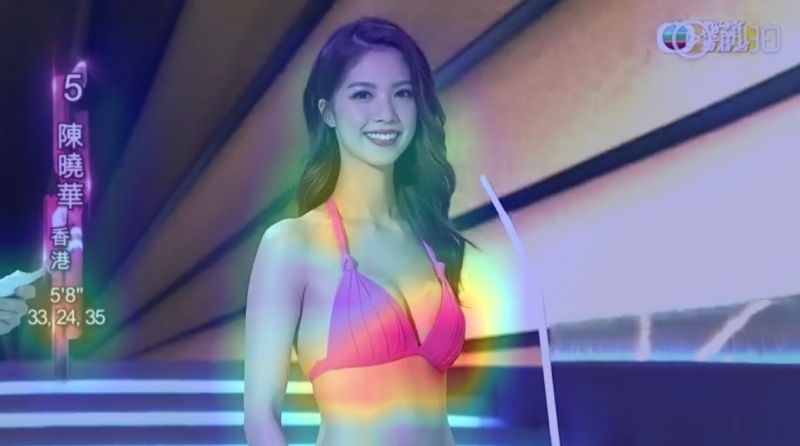

In [ ]:

npic=np.array(torchvision.transforms.ToPILImage()(pic).convert('RGB'))
print(npic.shape)

cam = cv2.resize(cam,(npic.shape[1],npic.shape[0]))
print(cam.shape)

heatmap=cv2.applyColorMap(np.uint8(cam),cv2.COLORMAP_JET)

cam_img=npic*0.7+heatmap*0.3
print(cam_img.shape)
#display(Image.fromarray(heatmap[:,:,::-1]))
display(torchvision.transforms.ToPILImage()(np.uint8(cam_img[:,:,::-1])))